In [1]:
from rostering_solver import Instance, Solver
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
city = 'berlin'
demand_baseline = "1.00"
week_demand_type = "doublepeak" # "fixed" demand_type
weekend_demand_type = "uniform"

outsourcing_cost_multiplier = 1.5
model = "flex" # "fixed" # "flex"
multiple_scenario = True

read_instance_file = False

min_multiple_scenario = float('inf')

In [3]:
if read_instance_file:
    demand_file = f'{city}_db={demand_baseline}_dt={week_demand_type}.csv'
    print(demand_file)

    demand_df = pd.read_csv(demand_file, index_col=0)
    demand_df['area_id'] = demand_df['area_id'].astype(str) 
    days_ = []
    for i in range(7):
        days_.append([i, "1.00", "uniform"])
    days = pd.DataFrame(days_, columns=['day', 'demand_baseline', 'demand_type']) 
else:
    # Generate instance file
    # Generate several days instances 
    days = pd.DataFrame([
        [0, demand_baseline, week_demand_type], # Monday
        [1, demand_baseline, week_demand_type], # Tuesday
        [2, demand_baseline, week_demand_type], # Wednesday
        [3, demand_baseline, week_demand_type], # Thursday
        [4, demand_baseline, week_demand_type], # Friday
        [5, demand_baseline, weekend_demand_type], # Satuday
        [6, demand_baseline, weekend_demand_type], # Sunday
    ], columns=['day', 'demand_baseline', 'demand_type']
    )

    demand = []
    area_region_map = None

    for i, row in days.iterrows():
        demand_baseline, demand_type = row['demand_baseline'], row['demand_type']
        key = f'{city}_db={demand_baseline}_dt={demand_type}'

        instance_file = f'../instances/{city}_db={demand_baseline}_dt={demand_type}.json'
        with open(instance_file, 'r') as file:
            instance_data = json.load(file)

        if area_region_map is None:
            regions = instance_data['geography']['city']['regions']
            area_region_map = {}
            for region in regions:
                areas = region['areas'] 
                for area in areas:
                    area_region_map[area['id']] = region['id']
        
        if multiple_scenario:
            if instance_data['num_scenarios'] < min_multiple_scenario:
                min_multiple_scenario = instance_data['num_scenarios']
                
            for scenario in range(instance_data['num_scenarios']):
                data_ = (
                    pd.DataFrame(instance_data['scenarios'][scenario]['data'])
                    .assign(
                        day = row['day'],
                        scenario = scenario
                    )
                )
                demand.append(data_)
        else:
            scenario = random.randint(0, instance_data['num_scenarios']-1)
            data_ = (
                pd.DataFrame(instance_data['scenarios'][scenario]['data'])
                .assign(
                    day = row['day']
                )
            )
            demand.append(data_)

In [4]:
if multiple_scenario:
    demand_ = []
    demand_scenarios_df = pd.concat(demand)
    for theta in range(8):
        demand_scenarios_df[f'demand_{theta}'] = demand_scenarios_df['demand'].apply(lambda x: x[theta])
        demand_scenarios_df[f'required_couriers_{theta}'] = demand_scenarios_df['required_couriers'].apply(lambda x: x[theta])

        demand_scenarios_df.groupby(['area_id', 'day'])[f'demand_{theta}'].mean()
        demand_.append( pd.concat([demand_scenarios_df.groupby(['area_id', 'day'])[f'demand_{theta}'].mean().apply(lambda x: round(x, 2)).to_frame(), 
                                  demand_scenarios_df.groupby(['area_id', 'day'])[f'required_couriers_{theta}'].mean().apply(lambda x: round(x)).to_frame()], axis='columns'
                                  ))
        
    demand_df = pd.concat(demand_, axis='columns').reset_index()
    demand_df['demand'] = demand_df[[ f'demand_{theta}' for theta in range(8) ]].apply(lambda x: list(x), axis=1)
    demand_df['required_couriers'] = demand_df[[ f'required_couriers_{theta}' for theta in range(8) ]].apply(lambda x: list(x), axis=1)

else:
    demand_df = pd.concat(demand)

demand_df['region_id'] = demand_df['area_id'].map(area_region_map)
demand_df = demand_df[['day', 'region_id', 'area_id', 'demand', 'required_couriers']]
demand_df.head(20)

,day,region_id,area_id,demand,required_couriers
0,0,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
1,1,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
2,2,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
3,3,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
4,4,1,10115,"[0.3, 1.83, 3.83, 3.6, 3.33, 3.83, 1.97, 0.37]","[0, 1, 1, 1, 1, 1, 1, 0]"
5,5,1,10115,"[2.57, 2.13, 2.43, 2.03, 2.5, 2.4, 2.7, 2.33]","[1, 1, 1, 1, 1, 1, 1, 1]"
6,6,1,10115,"[2.57, 2.13, 2.43, 2.03, 2.5, 2.4, 2.7, 2.33]","[1, 1, 1, 1, 1, 1, 1, 1]"
7,0,1,10117,"[0.07, 1.9, 3.4, 2.67, 2.77, 3.67, 1.3, 0.17]","[0, 1, 1, 1, 1, 1, 1, 0]"
8,1,1,10117,"[0.07, 1.9, 3.4, 2.67, 2.77, 3.67, 1.3, 0.17]","[0, 1, 1, 1, 1, 1, 1, 0]"
9,2,1,10117,"[0.07, 1.9, 3.4, 2.67, 2.77, 3.67, 1.3, 0.17]","[0, 1, 1, 1, 1, 1, 1, 0]"


In [5]:
# READ SHIFTS
key = f'{city}_db={demand_baseline}_dt={demand_type}'

shifts_file = f'../shifts/{city}_db={demand_baseline}_dt={demand_type}.json'
with open(shifts_file, 'r') as file:
    shifts_data = json.load(file)

shifts_df = (
    pd.DataFrame(shifts_data).query(f'outsourcing_cost_multiplier == {outsourcing_cost_multiplier} & demand_type == "{demand_type}" & model == "{model}"')
    .query('regional_multiplier == 1.5 & global_multiplier == 0.8')
)

shifts_df.head(10)

,instance_file,city,demand_baseline,demand_type,model,max_n_shifts,outsourcing_cost_multiplier,regional_multiplier,global_multiplier,region,shifts_start,shifts_end
744,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,0,"{'0': 0, '1': 3, '2': 4}","{'0': 4, '1': 7, '2': 8}"
745,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,1,"{'0': 0, '1': 2}","{'0': 4, '1': 6}"
746,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,2,{'0': 0},{'0': 4}
747,berlin_db=1.00_dt=uniform.json,berlin,1.0,uniform,flex,NaN,1.5,1.5,0.8,3,"{'0': 0, '1': 1}","{'0': 4, '1': 5}"


In [26]:
region_population = {}
for region in regions:
    region_population[region] = instance_data['geography']['city']['regions'][region]['population']

region_population

{0: 251633, 1: 241770, 2: 236834, 3: 244364}

In [6]:
if multiple_scenario:
    period_demands =  demand_scenarios_df.set_index(['area_id', 'day', 'scenario'])['demand'].to_dict()
    period_couriers =  demand_scenarios_df.set_index(['area_id', 'day', 'scenario'])['required_couriers'].to_dict()
else:
    demand_df['scenario'] = 0
    period_demands = demand_df.set_index(['area_id', 'day', 'scenario'])['demand'].to_dict()
    period_couriers = demand_df.set_index(['area_id', 'day', 'scenario'])['required_couriers'].to_dict()

In [7]:
# INPUT DATA
region_area_map = { k: list(v) for k, v in demand_df.groupby('region_id').agg({'area_id': 'unique'}).to_dict()['area_id'].items()}
area_map = {a: i for i, a in enumerate(list(demand_df['area_id'].unique())) }
areas = list(demand_df['area_id'].unique())

shifts_start = shifts_df.set_index('region')['shifts_start'].to_dict()
shifts_end = shifts_df.set_index('region')['shifts_end'].to_dict()

print(shifts_start)
print(shifts_end)

{0: {'0': 0, '1': 3, '2': 4}, 1: {'0': 0, '1': 2}, 2: {'0': 0}, 3: {'0': 0, '1': 1}}
{0: {'0': 4, '1': 7, '2': 8}, 1: {'0': 4, '1': 6}, 2: {'0': 4}, 3: {'0': 4, '1': 5}}


In [38]:
n_employ = 10
region_default = 0

region_employees = {region_default: n_employ}
for region in regions[1:]:
    region_employees[region] = int(np.round(region_population[region] / region_population[region_default] * n_employ))

region_employees

{0: 10, 1: 10, 2: 9, 3: 10}

In [40]:
# ALL REGIONS MODEL 
regions = [0, 1, 2, 3]
if multiple_scenario:
    n_scenarios = int(min_multiple_scenario)
else:
    n_scenarios = 1

print(f'Number of scenarios: {n_scenarios}')

i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end, n_scenarios=n_scenarios)

sol = Solver(i)
sol.solve(time_limit=10)
sol.summary_results()

Number of scenarios: 30
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 102085 rows, 228912 columns and 866851 nonzeros
Model fingerprint: 0xa7434a4a
Model has 24115 quadratic constraints
Variable types: 99120 continuous, 129792 integer (129792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 98063 rows and 202967 columns
Presolve time: 4.69s
Presolved: 4022 rows, 25945 columns, 69525 nonzeros
Variable types: 4640 continuous, 21305 integer (21305 binary)
Found heuristic solution: objective 9490.0333333
Found heuristic solution: objective 9381.3333333

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    7343    

{'regions': [0, 1, 2, 3],
 'global_employees': 39,
 'region_employees': {0: 10, 1: 10, 2: 9, 3: 10},
 'obj_value': 6550.208333336854,
 'gap': 0.0014382494200839203,
 'elapsed_time': 10.066579103469849,
 'status': 9,
 'hiring_costs': 936.0,
 'outsourcing_costs': 5614.208333336854,
 'exec_time': 10.140144109725952,
 'n_variables': 228912,
 'n_constraints': 102085,
 'n_nonzeroes': 866851}

In [9]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in sol.employees:
    for a in areas:
        for theta in sol.Theta:
            for d in sol.D:
                selected_shift = None
                for p in sol.shifts:
                    if sol.r_var[e, p, d].X > 0.5:
                        selected_shift = p
                        break
                    
                if sol.k_var[e, sol.i.area_map[a], theta, d].X > 0.5:
                    area_employee_assignment.append([e, a, theta, d, selected_shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])
area_employee_assignment_df['region'] = area_employee_assignment_df['area'].map(area_region_map)
area_employee_assignment_df

,employee,area,period,day,shift,region
0,0,10245,3,1,0,0
1,0,10245,4,4,1,0
2,0,10247,1,1,0,0
3,0,10247,2,1,0,0
4,0,10247,3,2,1,0
...,...,...,...,...,...,...
451,18,10715,2,1,1,3
452,18,10715,4,3,1,3
453,18,10717,3,4,1,3
454,18,10717,5,3,1,3


In [10]:
area_employee_assignment_df.groupby(['employee']).agg({'shift': 'unique', 'region':'unique', 'area':['nunique', 'count']}).head(20)

shift region    area      
          unique unique nunique count
employee                             
0         [0, 1]    [0]       5    24
1         [1, 0]    [0]       5    24
2         [1, 0]    [0]       5    24
3            [1]    [1]       5    24
4            [1]    [1]       6    24
5         [1, 0]    [1]       4    24
6         [1, 0]    [1]       6    24
7            [0]    [2]       6    24
8            [0]    [2]       6    24
9            [0]    [2]       6    24
10           [0]    [2]       6    24
11           [0]    [2]       5    24
12           [1]    [3]       6    24
13        [0, 1]    [3]       7    24
14        [1, 0]    [3]       9    24
15           [1]    [3]       7    24
16           [1]    [3]       7    24
17        [1, 0]    [3]       9    24
18           [1]    [3]       9    24

In [11]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

,employee,area,period,day,shift,region
22,0,10317,3,0,1,0
20,0,10315,4,0,1,0
18,0,10249,5,0,1,0
12,0,10247,6,0,1,0
2,0,10247,1,1,0,0
3,0,10247,2,1,0,0
0,0,10245,3,1,0,0
21,0,10315,4,1,0,0
4,0,10247,3,2,1,0
6,0,10247,4,2,1,0


# Analysis

In [41]:
# Hiring costs
hiring_costs = sum([ sum([sol.cost_couriers[a, theta, d] * sol.k_var[e, a, theta, d].X for e in sol.E[r]]) 
            for r in sol.R for a in sol.A[r] for theta in sol.Theta for d in sol.D])

# Outsourcing
outsourcing_costs = sol.m.ObjVal - hiring_costs

print(hiring_costs, outsourcing_costs)

936.0 5614.208333336854


In [14]:
# Parcels outsourced
outsourced = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D  if s.omega_var[s.i.area_map[a], theta, d].X > 0.5]) 
parcels_with_demand = sum([1 for a in s.i.areas for theta in s.Theta for d in s.D if s.couriers_needed[s.i.area_map[a], theta, d] > 0])

pct_outsourced = outsourced / parcels_with_demand * 100
print(pct_outsourced)

NameError: name 's' is not defined

In [ ]:
couriers_needed_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.couriers_needed[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'n_couriers'})
        .assign(day = d)
    )
    couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)

# Demand
deliveries_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'deliveries'})
        .assign(day = d)
    )
    deliveries_.append(area_day_data)

deliveries_df = pd.concat(deliveries_)

couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
couriers_needed_df.head()

# areas
area_period_days_df = (
    area_employee_assignment_df
    .groupby(['area', 'period', 'day'])
    .agg({'employee': ['count', 'unique']})
    .reset_index()
)
area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
area_period_days_df

# Outsourcing
outsourcing_shifts = []
for a in areas:
    for theta in s.Theta:
        for d in s.D:
            value = s.omega_var[s.i.area_map[a],theta,d].X
            #print(f'{a} {theta} {d} : {value}')
            if value > 0.0:
                outsourcing_shifts.append([a, theta, d, value])

outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

# Join all
whole_solution_df = (
    couriers_needed_df
    # Employees
    .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
    # Outsource
    .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
)
# DROP AREAS NOT IN REGION!!
whole_solution_df['region'] = whole_solution_df['area'].map(area_region_map)
whole_solution_df['employee_count'].fillna(0, inplace=True)

In [ ]:
whole_solution_df.query('deliveries != 0').sample(10)

,area,period,n_couriers,day,deliveries,employee_count,employees_assign,cost_outsource,region
216,10717,3,1.0,0,2.20,1.0,[18],NaN,3
3167,10719,5,1.0,6,1.50,0.0,NaN,2.250,3
1787,10407,6,1.0,3,2.30,0.0,NaN,3.450,1
1076,10367,2,1.0,2,3.70,0.0,NaN,5.550,0
832,10245,6,1.0,1,2.57,0.0,NaN,3.855,0
130,10319,2,1.0,0,4.77,0.0,NaN,7.155,0
759,10829,4,1.0,1,1.87,0.0,NaN,2.805,2
924,10717,7,0.0,1,0.03,0.0,NaN,NaN,3
1802,10627,6,1.0,3,0.93,0.0,NaN,1.395,3
2718,10179,6,1.0,5,2.53,0.0,NaN,3.795,1


# REGION MODEL

In [ ]:
# REGION MODEL 
region = 0
regions = [region]
region_employees = {region:30}

#shifts_start = {region: shifts_df.set_index('region')['shifts_start'].to_dict()[region]}
#shifts_end = {region: shifts_df.set_index('region')['shifts_end'].to_dict()[region]}

i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()
s.summary_results()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2870 rows, 103144 columns and 51920 nonzeros
Model fingerprint: 0x667cd12d
Model has 21000 quadratic constraints
Variable types: 3304 continuous, 99840 integer (99840 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 160 rows and 87864 columns
Presolve time: 0.19s
Presolved: 2710 rows, 15280 columns, 47260 nonzeros
Variable types: 0 continuous, 15280 integer (15230 binary)
Found heuristic solution: objective 2803.1400000
Found heuristic solution: objective 2681.5350000

Root relaxation: objective 7.200000e+02, 4345 iterations, 0.16 seconds (0.15 work units)

    Nodes    |    Current Node    |     Ob

{'regions': [0],
 'n_employees': 30,
 'obj_value': 728.25,
 'lower_bound': 720.0000000000006,
 'elapsed_time': 5.143688917160034,
 'status': 11,
 'hiring_costs': 720.0,
 'outsourcing_costs': 8.25,
 'exec_time': 5.172454833984375,
 'n_variables': 103144,
 'n_constraints': 2870,
 'n_nonzeroes': 51920}

# Optimal region result

In [ ]:
results = []
region_employees = {}

# Iterate over regions and employees
for reg in [0, 1, 2, 3]:
    print(f'Region: {reg}')
    regions = [reg]
    for n_employees in tqdm([10, 15, 16, 17, 20, 25, 30, 60]):
        region_employees[region] = n_employees
        i = Instance(regions=regions, areas=areas, 
            region_area_map=region_area_map, area_map=area_map, 
            period_demands=period_demands, period_couriers=period_couriers,
            region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
            shifts_start=shifts_start, shifts_end=shifts_end)

        s = Solver(i)
        s.solve()
        print('-----', n_employees, s.summary_results()['obj_value'])
        results.append(s.summary_results())
    break

Region: 0


  0%|          | 0/8 [00:00<?, ?it/s]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1320 rows, 36584 columns and 16910 nonzeros
Model fingerprint: 0xa558d446
Model has 4200 quadratic constraints
Variable types: 3304 continuous, 33280 integer (33280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 264 rows and 31858 columns
Presolve time: 0.08s
Presolved: 1056 rows, 4726 columns, 13616 nonzeros
Variable types: 0 continuous, 4726 integer (4645 binary)
Found heuristic solution: objective 2392.5000000

Root relaxation: objective 1.120450e+03, 2291 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

 12%|█▎        | 1/8 [00:03<00:21,  3.06s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1700 rows, 53224 columns and 25085 nonzeros
Model fingerprint: 0x3482d894
Model has 6300 quadratic constraints
Variable types: 3304 continuous, 49920 integer (49920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 324 rows and 46343 columns
Presolve time: 0.12s
Presolved: 1376 rows, 6881 columns, 20216 nonzeros
Variable types: 0 continuous, 6881 integer (6800 binary)
Found heuristic solution: objective 2499.0000000

Root relaxation: objective 7.177500e+02, 3101 iterations, 0.06 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

 25%|██▌       | 2/8 [00:22<01:16, 12.79s/it]

----- 15 756.75
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1776 rows, 56552 columns and 26720 nonzeros
Model fingerprint: 0x60dbd822
Model has 6720 quadratic constraints
Variable types: 3304 continuous, 53248 integer (53248 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 336 rows and 49240 columns
Presolve time: 0.13s
Presolved: 1440 rows, 7312 columns, 21536 nonzeros
Variable types: 0 continuous, 7312 integer (7231 binary)
Found heuristic solution: objective 2520.0000000

Root relaxation: objective 6.631500e+02, 3004 iterations, 0.08 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

 38%|███▊      | 3/8 [02:17<04:57, 59.45s/it]

----- 16 699.75
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1852 rows, 59880 columns and 28355 nonzeros
Model fingerprint: 0x6c669c7f
Model has 7140 quadratic constraints
Variable types: 3304 continuous, 56576 integer (56576 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 348 rows and 52137 columns
Presolve time: 0.14s
Presolved: 1504 rows, 7743 columns, 22856 nonzeros
Variable types: 0 continuous, 7743 integer (7662 binary)
Found heuristic solution: objective 2544.0000000

Root relaxation: objective 6.117000e+02, 3229 iterations, 0.10 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

 50%|█████     | 4/8 [02:42<03:03, 45.98s/it]

----- 17 650.25
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2080 rows, 69864 columns and 33260 nonzeros
Model fingerprint: 0x1be3d4f0
Model has 8400 quadratic constraints
Variable types: 3304 continuous, 66560 integer (66560 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 384 rows and 60828 columns
Presolve time: 0.17s
Presolved: 1696 rows, 9036 columns, 26816 nonzeros
Variable types: 0 continuous, 9036 integer (8955 binary)
Found heuristic solution: objective 2605.5000000

Root relaxation: objective 5.280000e+02, 3606 iterations, 0.12 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

 62%|██████▎   | 5/8 [03:54<02:45, 55.15s/it]

----- 20 594.0
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2460 rows, 86504 columns and 41435 nonzeros
Model fingerprint: 0x4e087650
Model has 10500 quadratic constraints
Variable types: 3304 continuous, 83200 integer (83200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 444 rows and 75313 columns
Presolve time: 0.22s
Presolved: 2016 rows, 11191 columns, 33416 nonzeros
Variable types: 0 continuous, 11191 integer (11110 binary)
Found heuristic solution: objective 2707.5000000

Root relaxation: objective 6.180000e+02, 3123 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

 75%|███████▌  | 6/8 [04:20<01:30, 45.37s/it]

----- 25 634.5
Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2840 rows, 103144 columns and 49610 nonzeros
Model fingerprint: 0x5dfe705a
Model has 12600 quadratic constraints
Variable types: 3304 continuous, 99840 integer (99840 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 504 rows and 89798 columns
Presolve time: 0.25s
Presolved: 2336 rows, 13346 columns, 40016 nonzeros
Variable types: 0 continuous, 13346 integer (13265 binary)
Found heuristic solution: objective 2811.0000000

Root relaxation: objective 7.380000e+02, 3209 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

 88%|████████▊ | 7/8 [04:22<00:31, 31.09s/it]

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5120 rows, 202984 columns and 98660 nonzeros
Model fingerprint: 0xdbfec8bc
Model has 25200 quadratic constraints
Variable types: 3304 continuous, 199680 integer (199680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 864 rows and 176708 columns
Presolve time: 0.50s
Presolved: 4256 rows, 26276 columns, 79616 nonzeros
Variable types: 0 continuous, 26276 integer (26195 binary)
Found heuristic solution: objective 3516.7500000

Root relaxation: objective 1.458000e+03, 4176 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

100%|██████████| 8/8 [04:25<00:00, 33.18s/it]


In [ ]:
results_df = pd.DataFrame(results)
results_df = (
    results_df 
    .assign(
        obj_value = results_df['obj_value'].apply(lambda x: np.round(x, 1)),
        region = results_df['regions'].apply(lambda x: x[0])
    )
)
results_df

,regions,n_employees,obj_value,lower_bound,elapsed_time,status,hiring_costs,outsourcing_costs,exec_time,n_variables,n_constraints,n_nonzeroes,region
0,[0],10,1136.2,1136.25,2.597762,2,240.0,896.25,2.607988,36584,1320,16910,0
1,[0],15,756.8,756.75,18.993949,2,360.0,396.75,19.007908,53224,1700,25085,0
2,[0],16,699.8,699.75,114.276421,2,384.0,315.75,114.290921,56552,1776,26720,0
3,[0],17,650.2,650.25,24.639717,2,408.0,242.25,24.655775,59880,1852,28355,0
4,[0],20,594.0,594.00,70.592344,2,480.0,114.00,70.611805,69864,2080,33260,0
5,[0],25,634.5,634.50,25.358129,2,600.0,34.50,25.379035,86504,2460,41435,0
6,[0],30,738.0,738.00,0.460277,2,720.0,18.00,0.485059,103144,2840,49610,0
7,[0],60,1458.0,1458.00,0.699688,2,1440.0,18.00,0.750034,202984,5120,98660,0


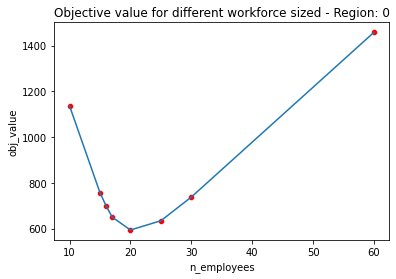

In [ ]:
sns.lineplot(data=results_df.query('region == 0'), x='n_employees', y='obj_value')
sns.scatterplot(data=results_df.query('region == 0'), x='n_employees', y='obj_value', color='red')
plt.title(f"Objective value for different workforce sized - Region: {region}")  # Adding title
plt.show()

In [ ]:
# REGION RESULTS
region = 0
selected_areas = s.i.region_area_map[region]

region_results = results_df.query(f'region == {region}')

# OPTIMAL SOLUTION
optimal_n_employees = int(region_results.query(f'obj_value == {results_df["obj_value"].min()}')['n_employees'].values[0])
region_employees = {}
region_employees[region] = optimal_n_employees

i = Instance(regions=[region], areas=areas, 
    region_area_map=region_area_map, area_map=area_map, 
    period_demands=period_demands, period_couriers=period_couriers,
    region_employees=region_employees, min_hours_worked=6*8, max_hours_worked=6*8, max_unique_starts=2,
    shifts_start=shifts_start, shifts_end=shifts_end)

s = Solver(i)
s.solve()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2080 rows, 69864 columns and 33260 nonzeros
Model fingerprint: 0x1be3d4f0
Model has 8400 quadratic constraints
Variable types: 3304 continuous, 66560 integer (66560 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 384 rows and 60828 columns
Presolve time: 0.16s
Presolved: 1696 rows, 9036 columns, 26816 nonzeros
Variable types: 0 continuous, 9036 integer (8955 binary)
Found heuristic solution: objective 2605.5000000

Root relaxation: objective 5.280000e+02, 3606 iterations, 0.11 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

In [ ]:
# Area Employee assignment (for each region)
area_employee_assignment = []
for e in s.employees:
    for a in areas:
        for theta in s.Theta:
            for d in s.D:
                for p in s.shifts:
                    shift = int(s.r_var[e, p, d].X)
                value = s.k_var[e, s.i.area_map[a], theta, d].X
                if value > 0.5:
                    area_employee_assignment.append([e, a, theta, d, shift])

area_employee_assignment_df = pd.DataFrame(area_employee_assignment, columns=['employee', 'area', 'period', 'day', 'shift'])

In [ ]:
area_employee_assignment_df.query('employee == 0').sort_values(['day', 'period'])

,employee,area,period,day,shift
5,0,10249,2,1,0
13,0,10317,3,1,0
3,0,10247,4,1,0
16,0,10318,5,1,0
12,0,10317,2,2,0
2,0,10247,3,2,0
19,0,10367,5,2,0
18,0,10365,6,2,0
7,0,10315,2,3,0
0,0,10245,4,3,0


In [ ]:
couriers_needed_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.couriers_needed[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'n_couriers'})
        .assign(day = d)
    )
    couriers_needed_.append(area_day_data)

couriers_needed_df = pd.concat(couriers_needed_)

# Demand
deliveries_ = []
for d in s.D:
    data = (
        pd.DataFrame(s.deliveries[:,:,d], index=areas, columns=s.Theta).reset_index()
        .rename(columns={'index': 'area'})
        #.assign(day = d)
    )

    area_day_data = (
        pd.melt(data, id_vars=['area'], value_vars=set(data.columns).difference('area'))
        .rename(columns={'variable': 'period', 'value': 'deliveries'})
        .assign(day = d)
    )
    deliveries_.append(area_day_data)

deliveries_df = pd.concat(deliveries_)

couriers_needed_df = pd.merge(couriers_needed_df, deliveries_df, on=['area', 'period', 'day'])
couriers_needed_df.head()

# areas
area_period_days_df = (
    area_employee_assignment_df
    .groupby(['area', 'period', 'day'])
    .agg({'employee': ['count', 'unique']})
    .reset_index()
)
area_period_days_df.columns = ['area', 'period', 'day', 'employee_count', 'employees_assign']
area_period_days_df

# Outsourcing
outsourcing_shifts = []
for a in areas:
    for theta in s.Theta:
        for d in s.D:
            value = s.omega_var[s.i.area_map[a],theta,d].X
            #print(f'{a} {theta} {d} : {value}')
            if value > 0.0:
                outsourcing_shifts.append([a, theta, d, value])

outsourcing_shifts_df = pd.DataFrame(outsourcing_shifts, columns=['area', 'period', 'day', 'cost_outsource'])

# Join all
whole_solution_df = (
    couriers_needed_df
    # Employees
    .merge(area_period_days_df,  on=['area', 'period', 'day'], how='left')
    # Outsource
    .merge(outsourcing_shifts_df, on=['area', 'period', 'day'], how='left')
)
# DROP AREAS NOT IN REGION!!
whole_solution_df = whole_solution_df.query(f'area.isin({selected_areas})')
whole_solution_df['employee_count'].fillna(0, inplace=True)

whole_solution_df.query('deliveries != 0').head(30)

,area,period,n_couriers,day,deliveries,employee_count,employees_assign,cost_outsource
8,10249,0,1.0,0,1.0,1.0,[14],NaN
11,10318,0,1.0,0,1.0,1.0,[9],NaN
65,10245,1,1.0,0,2.0,1.0,[3],NaN
66,10247,1,1.0,0,2.0,1.0,[14],NaN
67,10249,1,1.0,0,1.0,0.0,NaN,1.5
68,10315,1,1.0,0,2.0,1.0,[15],NaN
69,10317,1,1.0,0,1.0,0.0,NaN,1.5
70,10318,1,1.0,0,2.0,0.0,NaN,3.0
71,10319,1,1.0,0,2.0,1.0,[9],NaN
72,10365,1,1.0,0,2.0,0.0,NaN,3.0


In [ ]:
employees_shifts = []
for e in s.employees:
    for p in s.shifts:
        for d in s.D:
            value = s.r_var[e, p, d].X
            if value > 0.5:
                employees_shifts.append({'employee': e, 'shift': p, 'day':d, 'value': value})

employees_shifts_df = pd.DataFrame(employees_shifts)
employees_shifts_df.head()

day_employees_shifts_df = employees_shifts_df.groupby(['day', 'shift'])['value'].sum().reset_index()
day_employees_shifts_df

,day,shift,value
0,0,0,5.0
1,0,1,12.0
2,1,0,3.0
3,1,1,13.0
4,2,0,2.0
5,2,1,15.0
6,3,0,5.0
7,3,1,14.0
8,4,0,4.0
9,4,1,12.0


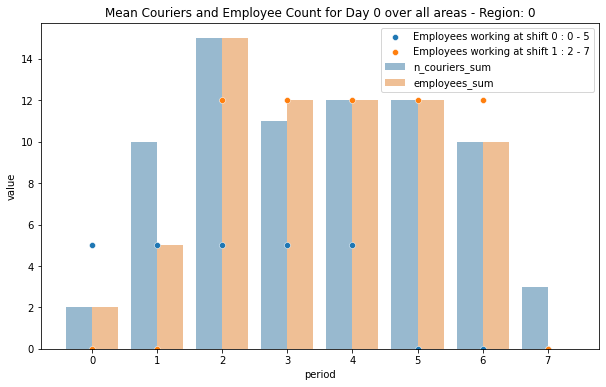

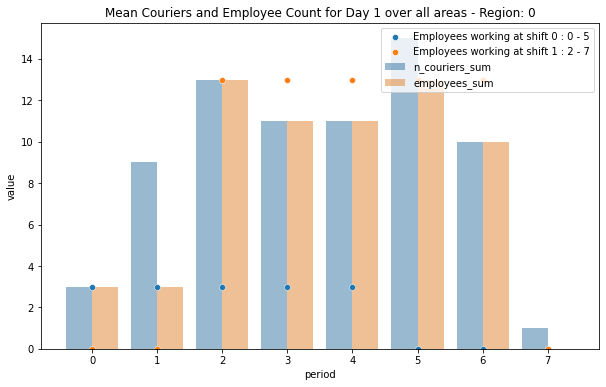

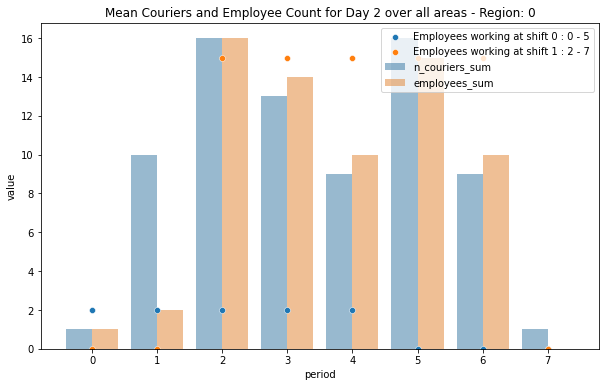

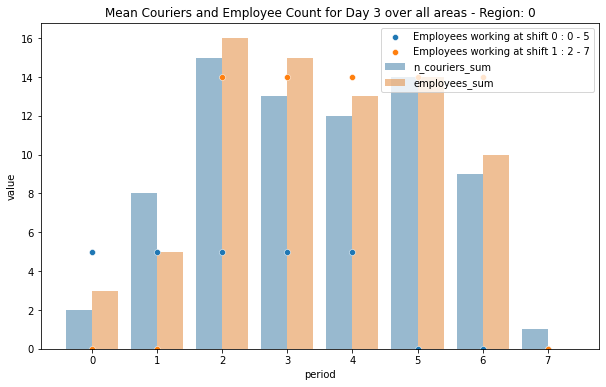

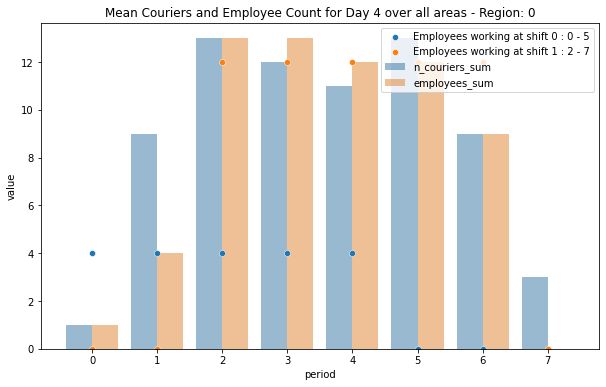

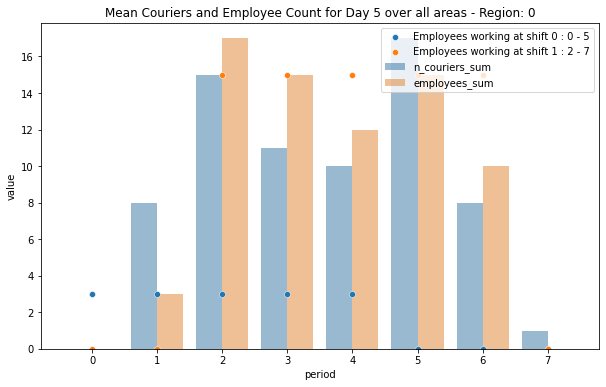

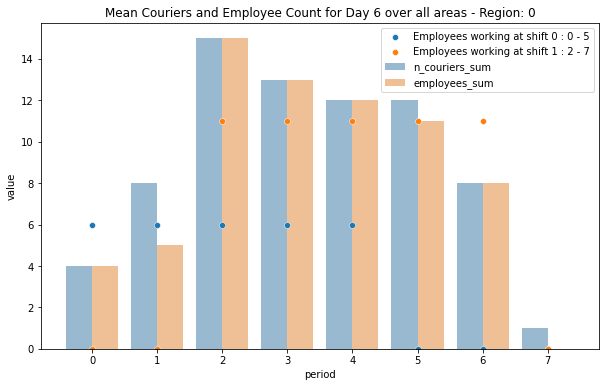

In [ ]:
for d in s.D:
    _ = whole_solution_df.query(f'day == {d}').groupby('period').agg({'n_couriers': 'sum', 'employee_count': 'sum'})
    _.columns = ['n_couriers_sum', #'n_couriers_mean', 'n_couriers_min', 'n_couriers_max',
                 'employees_sum' #'employees_mean', 'employees_min', 'employees_max'
                ]
    
    a = pd.melt(_.reset_index(), id_vars='period', value_vars=['n_couriers_sum', 'employees_sum'])
    plt.figure(figsize=(10, 6))

    sns.barplot(data=a, x='period', y='value', hue='variable', alpha=0.5)

    # SHIFTS
    for key, x in s.i.shifts_start[region].items():
        start = s.i.shifts_start[region][key]
        end = s.i.shifts_end[region][key]+1
        
        if int(key) in list(day_employees_shifts_df.query(f'day == {d}')['shift'].values):
            workers = day_employees_shifts_df.query(f'shift == {int(key)} & day == {d}')['value'].values[0]
            #periods_ = [x for x in range(8) if i in range(start, end)]

            sns.scatterplot(x=[p for p in range(8)], y=[workers if i >= start and i < end else 0 for i in range(8)], label=f'Employees working at shift {key} : {start} - {end}')

    plt.title(f"Mean Couriers and Employee Count for Day {d} over all areas - Region: {region}")  # Adding title
    plt.legend(loc='upper right')  # Displaying legend
    
    plt.show()